## Importing Libraries

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import time
import seaborn as sns
import plotly.express as px
import numpy as np
import warnings
from tensorflow.keras.layers import LSTM, Dense, Input, Attention, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

## Loading Data

In [2]:
df = pd.read_csv(r"bovespa_indexes.csv")

In [3]:
df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,^BVSP,70045.0,70045.0,70081.0,68587.0,68587.0,1655400.0
1,2010-01-05,^BVSP,70240.0,70240.0,70595.0,69928.0,70046.0,1984200.0
2,2010-01-06,^BVSP,70729.0,70729.0,70937.0,70016.0,70237.0,2243600.0
3,2010-01-07,^BVSP,70451.0,70451.0,70723.0,70045.0,70723.0,1555000.0
4,2010-01-08,^BVSP,70263.0,70263.0,70766.0,70158.0,70455.0,1634400.0


In [4]:
df.duplicated().sum()

0

In [5]:
df.dtypes

,0
Date,object
Symbol,object
Adj Close,float64
Close,float64
High,float64
Low,float64
Open,float64
Volume,float64


In [6]:
df["Symbol"].value_counts()

,count
Symbol,
^BVSP,3609
^IVBX,2877
^IBX50,2876
ISEE,1
BDRX,1
MLCX,1
IBRA,1
IDIV,1
IFIX,1


# Cleaning Data

Converting the date column to datetime:

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
df.dtypes

,0
Date,datetime64[ns]
Symbol,object
Adj Close,float64
Close,float64
High,float64
Low,float64
Open,float64
Volume,float64


For this analysis it will only be needed the "Adj Closing" and "Date" columns of "^BVSP" symbol:

In [9]:
df = df[df["Symbol"] == "^BVSP"][["Date", "Adj Close"]].set_index("Date").sort_index()

In [10]:
df.head()

,Adj Close
Date,
2010-01-04,70045.0
2010-01-05,70240.0
2010-01-06,70729.0
2010-01-07,70451.0
2010-01-08,70263.0


In [11]:
type(df)

pandas.core.frame.DataFrame

Adding weekends and

In [12]:
idx = pd.Series((pd.date_range(min(df.index), max(df.index))))
df = df.reindex(idx, method="ffill")

In [13]:
y = df["Adj Close"]

In [14]:
y

,Adj Close
2010-01-04,70045.0
2010-01-05,70240.0
2010-01-06,70729.0
2010-01-07,70451.0
2010-01-08,70263.0
2010-01-09,70263.0
2010-01-10,70263.0
2010-01-11,70433.0
2010-01-12,70076.0
2010-01-13,70385.0


# Data Analysis

In [15]:
fig = px.line(data_frame=y, y=y, title= "IBOV index")
fig.update_layout(yaxis_title= "IBOV", xaxis_title= "Year")
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


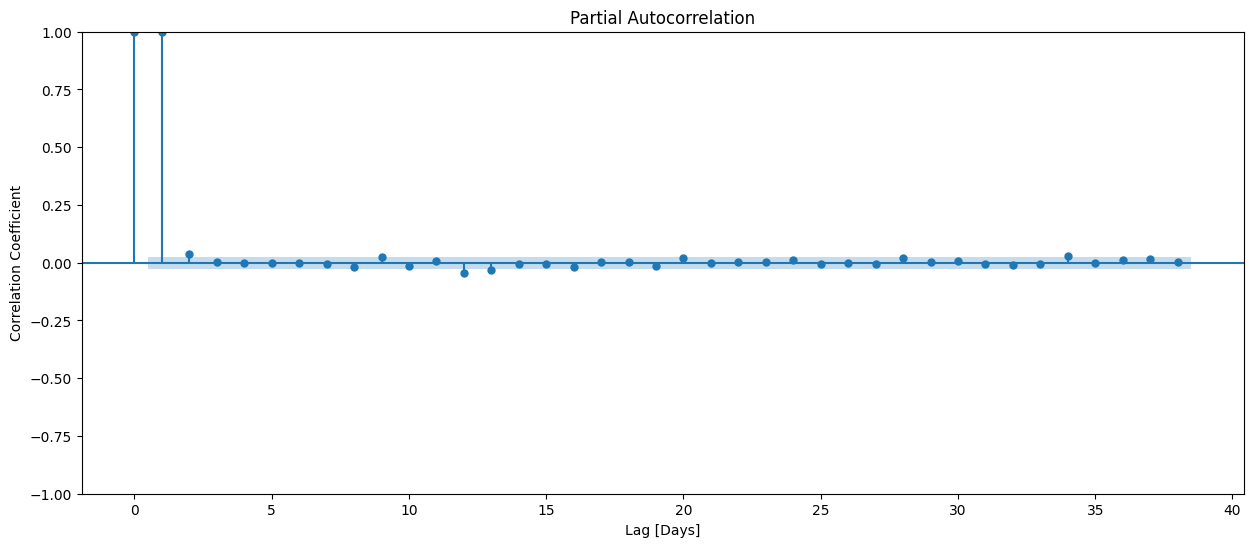

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

The graph above shows that there is a possible good predictive power with 19 lags.

# Model Building

# Spliting the Data

In [17]:
cutoff_test = int(len(y)*0.90)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

Setting 90% for train and 10 % for test.

# Defining Baseline

In [18]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean of the IBOV:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean of the IBOV: 75202.64
Baseline MAE: 20841.62


# AutoReg Model

### Creating the pipeline:

Testing Lags for AutoReg model:

In [19]:
# Create dictionary to store MAEs
mae_grid = dict()
p_params = range(1,19)
# Outer loop: Iterate through possible values for p
for p in p_params:
    mae_grid[p] = list()
    # Note start time
    start_time = time.time()
    # Train model
    model = AutoReg(y_train, lags=p).fit()
    # Calculate model training time
    elapsed_time = round(time.time() - start_time, 2)
    print(f"Trained AutoReg {p} in {elapsed_time} seconds.")
    # Generate in-sample (training) predictions
    y_pred = model.predict().dropna()
    # Calculate training MAE
    mae = mean_absolute_error(y_train[p:], y_pred)
    # Append MAE to list in dictionary
    mae_grid[p].append(mae)

Trained AutoReg 1 in 0.04 seconds.
Trained AutoReg 2 in 0.02 seconds.
Trained AutoReg 3 in 0.02 seconds.
Trained AutoReg 4 in 0.02 seconds.
Trained AutoReg 5 in 0.02 seconds.
Trained AutoReg 6 in 0.02 seconds.
Trained AutoReg 7 in 0.02 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

Trained AutoReg 8 in 0.02 seconds.
Trained AutoReg 9 in 0.02 seconds.
Trained AutoReg 10 in 0.02 seconds.
Trained AutoReg 11 in 0.02 seconds.
Trained AutoReg 12 in 0.02 seconds.
Trained AutoReg 13 in 0.02 seconds.
Trained AutoReg 14 in 0.02 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

Trained AutoReg 15 in 0.03 seconds.
Trained AutoReg 16 in 0.05 seconds.
Trained AutoReg 17 in 0.02 seconds.
Trained AutoReg 18 in 0.02 seconds.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [20]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4).style.background_gradient(axis=None)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,564.426600,569.893900,570.017700,570.234200,572.023900,572.328900,572.471100,573.201700,574.584200,575.797700,576.596900,582.906500,584.887800,585.001400,584.966900,585.752800,585.743700,585.578100


As the heatmap above shows, the best lag is 1.

In [21]:
model = AutoReg(y_train, lags=1).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



### Setting parameters:

In [22]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train[1:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 564.4266272852443


### Walk foward validation:

In [29]:
# Walk-forward validation
y_pred_wfv = pd.Series(dtype=np.float64)
history = y_train.copy()

for i in range(len(y_test)):
    model = AutoReg(history, lags=1).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test[next_pred.index]])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.

<ipython-input-29-34f477e3468c>:8: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/determinis

### Evaluating the model:

In [30]:
test_mae_ar = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae_ar, 2))

Test MAE (walk forward validation): 590.15


# Prediction vs Real Graph

In [31]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred_wfv": y_pred_wfv}
)
fig = px.line(df_pred_test, labels={"value":"IBOV"}, title= "Brazil Index prediction")
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# LSTM Model

In [54]:
# Loading Data
df = pd.read_csv(r"bovespa_indexes.csv")

# Data Cleaning
df["Date"] = pd.to_datetime(df["Date"])
df = df[df["Symbol"] == "^BVSP"][["Date", "Adj Close"]].sort_values(by="Date")
df.set_index("Date", inplace=True)
idx = pd.date_range(min(df.index), max(df.index))
df = df.reindex(idx, method="ffill")
df.index.name = 'Date'
y = df["Adj Close"]


## Scaling data

In [55]:
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

## Creating sequences

In [56]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 10
X, y_seq = create_sequences(y_scaled, SEQ_LENGTH)

In [58]:
cutoff_test = int(len(y_scaled)*0.90)
X_train, X_test = X[:cutoff_test], X[cutoff_test:]
y_train, y_test = y_seq[:cutoff_test], y_seq[cutoff_test:]
test_indices = df.index[SEQ_LENGTH + cutoff_test:]


## Building LSTM Model

In [60]:
input_layer = Input(shape=(SEQ_LENGTH, 1))
lstm_out = LSTM(50, return_sequences=True)(input_layer)
attention = Attention()([lstm_out, lstm_out])
context_vector = Concatenate()([lstm_out, attention])
lstm_out = LSTM(50)(context_vector)
output_layer = Dense(1)(lstm_out)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ (None, 10, 50)         │         10,400 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_5 (Attention)   │ (None, 10, 50)         │              0 │ lstm_9[0][0],          │
│                           │                        │                │ lstm_9[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 10, 100)        │              0 │ lstm_9[0][0],          │
│ (Concatenate)             │                        │                │ attention_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ (None, 50)             │         30,200 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             51 │ lstm_10[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 40,651 (158.79 KB)

 Trainable params: 40,651 (158.79 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [61]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0579 - val_loss: 0.0236
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0148 - val_loss: 0.0194
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0147 - val_loss: 0.0207
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0128 - val_loss: 0.0176
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0124 - val_loss: 0.0175
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0118 - val_loss: 0.0204
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0116 - val_loss: 0.0301
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0107 - val_loss: 0.0134
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0115 - val_loss: 0.0124
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0091 - val_loss: 0.0117
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0092 - val_loss: 0.0288
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 

## Making predictions

In [62]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


## Evaluating the model

In [63]:
test_mae_lstm = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_rescaled)
print("Test MAE (LSTM with attention):", round(test_mae_lstm, 2))

Test MAE (LSTM with attention): 1372.29


In [64]:
df_pred_test_lstm = pd.DataFrame(
    {
        "y_test": scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(),
        "y_pred": y_pred_rescaled.flatten()
    },
    index=test_indices
)

fig = px.line(df_pred_test_lstm, labels={"value":"IBOV"}, title="Brazil Index LSTM prediction")
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

